In [ ]:
datadir = 'workspace/competedata_train/'
libdir = 'workspace/'
outputdir = 'workspace/'
otherdir = 'workspace/'
train_bs_ = 16
valid_bs_ = 32
num_workers_ = 8

In [ ]:
class CFG:
    seed=42
    device='GPU' #### ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
           'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
           'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
    n_class=11
    accum_iter=1
    max_grad_norm=1000
    print_freq=100
    normalize_mean=[0.4824, 0.4824, 0.4824] # [0.485, 0.456, 0.406] [0.4824, 0.4824, 0.4824]
    normalize_std=[0.22, 0.22, 0.22] # [0.229, 0.224, 0.225] [0.22, 0.22, 0.22]
    
    suffix="1804" 
    fold_list=[3] 
    epochs=22 
    model_arch="resnet200d" # efficientnet,resnet200d
    img_size=640
    optimizer="Adam"
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup= "GradualWarmupSchedulerV3" # "GradualWarmupSchedulerV3"

    teacher= outputdir + "resnet200d_1013_fold3_epoch15_cv9666.pth"
    softlabel_csv = otherdir + "softlabeljason.csv"
    
    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
        epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1 # CosineAnnealingLR
    
    lr=1e-4 
    min_lr=1e-7
    weight_decay=0 

    dropout_ratio = 0
    mixup = 0
    temperature = 0.8
    filter_confidence = 0.3

    fix_mistake = True
    multihead = True
    gpu_parallel=True 
    n_early_stopping=15
    debug=True 

print(f"scheduler: {CFG.scheduler}")
print(f"scheduler_warmup: {CFG.scheduler_warmup}")
print(f"warmup_epo: {CFG.warmup_epo}")
print(f"warmup_factor: {CFG.warmup_factor}")
print("T_max:", CFG.T_max)
print("lr:", CFG.lr)
print("min_lr:", CFG.min_lr)
print("weight_decay:", CFG.weight_decay)

In [3]:
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    

import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import PIL.Image


import torch.optim as optim
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom

from sklearn.metrics import accuracy_score
import gc
from warnings import filterwarnings
filterwarnings("ignore")


from torch.cuda.amp import autocast, GradScaler
from torch.nn import DataParallel
device = torch.device('cuda')

# helper

In [4]:
train_df = pd.read_csv(f'{datadir}train.csv')
train_annotations_df = pd.read_csv(f'{datadir}train_annotations.csv')

def fix_mistake_label(train_df, train_annotations_df, ann_index, uid, old_label, correct_label):
    train_df.loc[train_df.StudyInstanceUID==uid, old_label] = 0
    train_df.loc[train_df.StudyInstanceUID==uid, correct_label] = 1
    train_annotations_df.loc[train_annotations_df.index==ann_index, 'label'] = correct_label
    

train_df['filepaths'] = train_df.StudyInstanceUID.apply(lambda x: f'{datadir}train/{x}.jpg')

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(train_df, train_df[CFG.target_cols], train_df['PatientID'])

DEBUG MODE...


In [5]:
 def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [6]:
map_csv_path = f"{otherdir}nihdata/dublicated entry from RANZCR and NIH.csv"
map_df = pd.read_csv(map_csv_path)[["original","dublicated"]]
map_df["original"] = map_df["original"].apply(lambda x: x.split("/")[-1].replace(".jpg", ""))
map_df["dublicated"] = map_df["dublicated"].apply(lambda x: x.split("/")[-1])
map_df

,original,dublicated
0,1.2.826.0.1.3680043.8.498.10000428974990117276...,00017747_033.png
1,1.2.826.0.1.3680043.8.498.10001065121843652267...,00020130_011.png
2,1.2.826.0.1.3680043.8.498.10001175380298620851...,00005079_015.png
3,1.2.826.0.1.3680043.8.498.10001274045312501651...,00014149_014.png
4,1.2.826.0.1.3680043.8.498.10001645884963994872...,00001836_125.png
...,...,...
28724,1.2.826.0.1.3680043.8.498.99971919985113251695...,00009689_010.png
28725,1.2.826.0.1.3680043.8.498.99974757496176821720...,00003857_001.png
28726,1.2.826.0.1.3680043.8.498.99979645057411935093...,00026202_001.png
28727,1.2.826.0.1.3680043.8.498.99989600335044826115...,00006057_006.png


In [7]:
main_df = pd.read_csv(CFG.softlabel_csv)

if "jason" in CFG.softlabel_csv:
    main_df.columns = ["filenames", "label0", "label1", "label2", "label3", "label4", "label5", "label6", "label7", "label8", "label9", "label10"]
    nih_filepath = pd.read_csv(f"{otherdir}nihdata/nih_filepath.csv")
    main_df = main_df.merge(nih_filepath,how="left",on="filenames")
else:
    main_df.columns = ["filepaths", "label0", "label1", "label2", "label3", "label4", "label5", "label6", "label7", "label8", "label9", "label10"]
    main_df["filenames"] = main_df["filepaths"].str.split("/").str[-1]
    
if ENV == "megstudio":
    main_df['filepaths'] = main_df['filepaths'].apply(lambda x: f'{otherdir}nihdata/{x}')

main_df = main_df[main_df[[f"label{i}" for i in range(11)]].apply(lambda x: any(x.to_numpy().astype(np.float32) > CFG.filter_confidence),axis=1)].reset_index(drop=True)
print("main_df.shape: ",main_df.shape)

main_df.shape:  (7600, 13)


In [8]:
main_df

,filenames,label0,label1,label2,label3,label4,label5,label6,label7,label8,label9,label10,filepaths
0,313723174271082992847610802266403640553-2_40kx...,0.263977,0.971830,0.058046,0.115751,0.035190,0.103237,0.064241,0.031253,0.135284,0.111808,0.002140,workspace/nihdata/images_013/image/31372317427...
1,313723174271082992847610802266403640553_w8dk8c...,0.395458,0.889053,0.042876,0.199371,0.031157,0.140293,0.018489,0.061885,0.260970,0.073879,0.001459,workspace/nihdata/images_013/image/31372317427...
2,49602503074420747438297888031645729553_n9jt8a.png,0.000157,0.004844,0.001350,0.002579,0.003383,0.000864,0.000865,0.047729,0.247102,0.938118,0.000174,workspace/nihdata/images_013/image/49602503074...
3,49602503074420747438297888031645729553_2_ut0yz...,0.000164,0.003283,0.001538,0.001811,0.003467,0.001202,0.001460,0.034316,0.272703,0.932392,0.000218,workspace/nihdata/images_013/image/49602503074...
4,122344634100249204350826448738624565922_2_waa6...,0.300136,0.955423,0.048831,0.089477,0.021619,0.385071,0.063774,0.110092,0.346649,0.099743,0.002346,workspace/nihdata/images_013/image/12234463410...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,216840111366964012819207061112010320084902578_...,0.000292,0.032446,0.993796,0.007028,0.037472,0.033262,0.966853,0.046874,0.087521,0.992204,0.002922,workspace/nihdata/images_013/image/21684011136...
7596,216840111366964012819207061112010320084806609_...,0.001462,0.007956,0.014008,0.003473,0.010672,0.016132,0.022602,0.028155,0.058452,0.996729,0.002935,workspace/nihdata/images_013/image/21684011136...
7597,216840111366964012768025509942010172085721341_...,0.001263,0.064572,0.968125,0.012512,0.055676,0.226393,0.835492,0.022144,0.087244,0.997261,0.006749,workspace/nihdata/images_013/image/21684011136...
7598,216840111366964012904401302362010328124037536_...,0.000332,0.004471,0.006208,0.002013,0.006536,0.001916,0.006110,0.050743,0.174881,0.965492,0.000275,workspace/nihdata/images_013/image/21684011136...


In [9]:
def cook_labels(y):
    mask = y < 0.5
    y[mask] = np.minimum(y[mask] ** CFG.temperature, 0.5)
    mask = ~mask
    y[mask] = np.maximum(1 - ((1 - y[mask]) ** CFG.temperature), 0.5)
    return y
main_df["labels"] = main_df[[f"label{i}" for i in range(11)]].apply(lambda x: cook_labels(x.to_numpy().astype(np.float32)), axis=1)

# DataSet

In [10]:
 def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
 
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
 
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

In [11]:
class TrainDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        if "labels" in self.df.columns:
            self.labels = self.df["labels"].values
        else:
            self.labels = df[CFG.target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.filepaths)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image']
                
        # img = img.transpose(0, 1).transpose(1,2).squeeze()
        label = torch.tensor(self.labels[index]).float()
        if self.mode == 'test':
            return img
        else:
            return img, label

In [12]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'train':
        return Compose([
                ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.8, 1), p=1.), 
                HorizontalFlip(p=0.5),
                HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.3),
                RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.4),
                CLAHE(clip_limit=(1,4), p=0.5),
                OneOf([GaussianBlur(),], p=0.2),
                Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
                Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
                ToTensorV2(),
                ])
        

    elif data == 'valid':
        return Compose([
                Resize(CFG.img_size, CFG.img_size),
                Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
                ToTensorV2(),
            ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


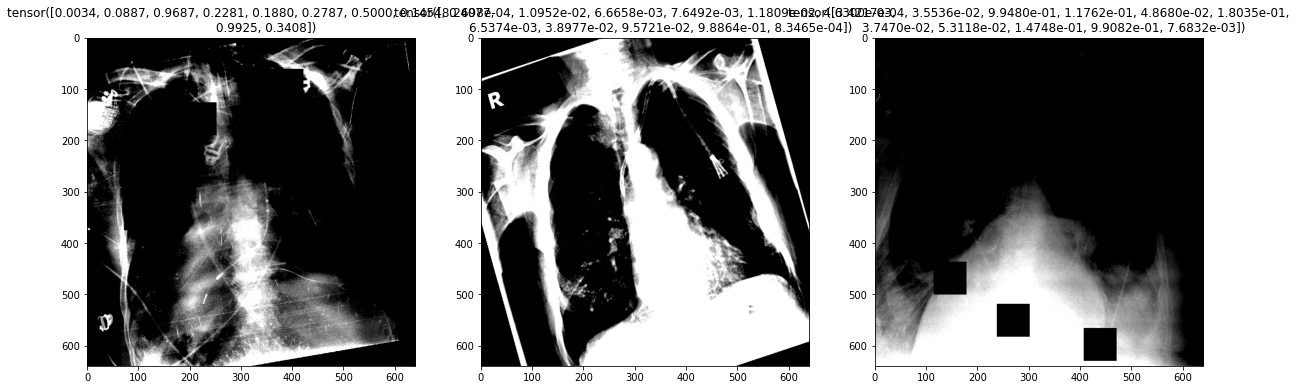

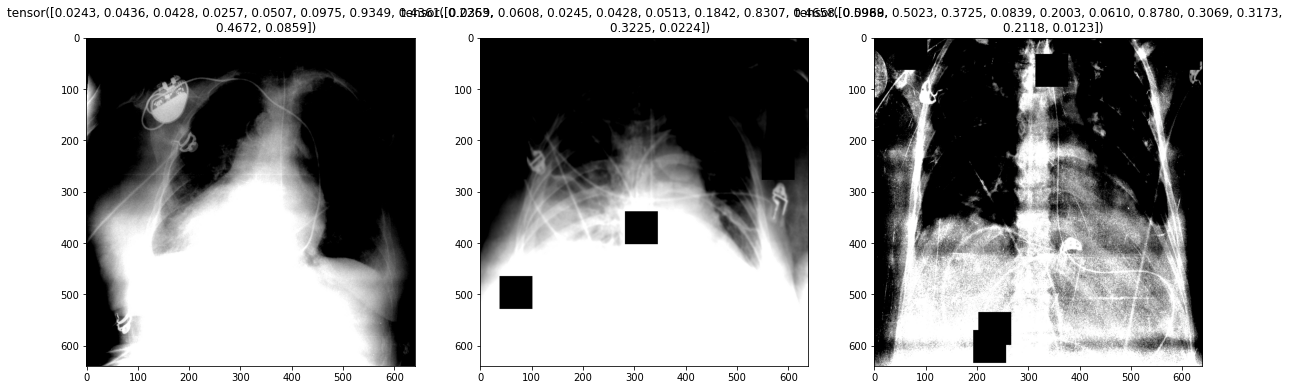

In [13]:
dataset_show = TrainDataset(main_df, "train", transform=get_transforms(data='train'))
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,3)
    for p in range(3):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        # axarr[p].imshow(img) # transform=None
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [14]:
class RanzcrClassifier(nn.Module):
    def __init__(self, model_arch, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if 'efficientnet' in CFG.model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.n_class)
        elif "resnet" in CFG.model_arch:
            n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(n_features, CFG.n_class)

    def forward(self, x):
        if 'efficientnet' in CFG.model_arch:
            return self.model(x)
        elif "resnet" in CFG.model_arch:
            bs = x.size(0)
            features = self.model(x)
            pooled_features = self.pooling(features).view(bs, -1)
            output = self.fc(pooled_features)
            return output

In [15]:
def get_activation(activ_name: str="relu"):
    """"""
    act_dict = {
        "relu": nn.ReLU(inplace=True),
        "tanh": nn.Tanh(),
        "sigmoid": nn.Sigmoid(),
        "identity": nn.Identity()}
    if activ_name in act_dict:
        return act_dict[activ_name]
    else:
        raise NotImplementedError
        

class Conv2dBNActiv(nn.Module):
    """Conv2d -> (BN ->) -> Activation"""
    
    def __init__(
        self, in_channels, out_channels,
        kernel_size, stride, padding,
        bias=False, use_bn=True, activ="relu"
    ):
        """"""
        super(Conv2dBNActiv, self).__init__()
        layers = []
        layers.append(nn.Conv2d(
            in_channels, out_channels,
            kernel_size, stride, padding, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(get_activation(activ))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward"""
        return self.layers(x)
        
    
class SpatialAttentionBlock(nn.Module):
    """Spatial Attention for (C, H, W) feature maps"""
    
    def __init__(
        self, in_channels,
        out_channels_list,
    ):
        """Initialize"""
        super(SpatialAttentionBlock, self).__init__()
        self.n_layers = len(out_channels_list)
        channels_list = [in_channels] + out_channels_list
        assert self.n_layers > 0
        assert channels_list[-1] == 1
        
        for i in range(self.n_layers - 1):
            in_chs, out_chs = channels_list[i: i + 2]
            layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="relu")
            setattr(self, f"conv{i + 1}", layer)
            
        in_chs, out_chs = channels_list[-2:]
        layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="sigmoid")
        setattr(self, f"conv{self.n_layers}", layer)
    
    def forward(self, x):
        """Forward"""
        h = x
        for i in range(self.n_layers):
            h = getattr(self, f"conv{i + 1}")(h)
            
        h = h * x
        return h



class MultiHeadResNet200D(nn.Module):
    def __init__(self, out_dims_head=[3, 4, 3, 1],  pretrained=False):
        self.base_name = "resnet200d_320"
        self.n_heads = len(out_dims_head)
        super(MultiHeadResNet200D, self).__init__()
        
        # # load base model
        base_model = timm.create_model(self.base_name, num_classes=sum(out_dims_head), pretrained=False)
        in_features = base_model.num_features
        
        if pretrained:
            pretrained_model_path = CFG.teacher
            state_dict = dict()
            for k, v in torch.load(pretrained_model_path, map_location='cpu')["model"].items():
                if k[:6] == "model.":
                    k = k.replace("model.", "")
                state_dict[k] = v
            base_model.load_state_dict(state_dict)
        
        # # remove global pooling and head classifier
        base_model.reset_classifier(0, '')
        
        # # Shared CNN Bacbone
        self.backbone = base_model
        
        # # Multi Heads.
        for i, out_dim in enumerate(out_dims_head):
            layer_name = f"head_{i}"
            layer = nn.Sequential(
                SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1),
                nn.Linear(in_features, in_features),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(in_features, out_dim))
            setattr(self, layer_name, layer)

    def forward(self, x):
        h = self.backbone(x)
        hs = [getattr(self, f"head_{i}")(h) for i in range(self.n_heads)]
        y = torch.cat(hs, axis=1)
        return y

In [16]:
def macro_multilabel_auc(label, pred):
    aucs = []
    for i in range(len(CFG.target_cols)):
        try:
            aucs.append(roc_auc_score(label[:, i], pred[:, i]))
        except ValueError:
            aucs.append(0)
    print(np.round(aucs, 4))
    return np.mean(aucs)

In [17]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    scaler = torch.cuda.amp.GradScaler()
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):
        images, targets = images.to(device), targets.to(device)
        if CFG.mixup > 0:
            images, targets = mixup_data(images, targets, alpha=CFG.mixup)
        with torch.cuda.amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            loss = loss / CFG.accum_iter
        scaler.scale(loss).backward()
        if (batch_idx + 1) % CFG.accum_iter == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()   
        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}, lr: {optimizer.param_groups[0]["lr"]:.7f}')
    loss_train = np.mean(losses)
    return loss_train


def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]
            loss = criterion(logits, targets)
            losses.append(loss.item())
            smooth_loss = np.mean(losses[-30:])
            bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')
            
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    #roc_auc = roc_auc_score(TARGETS.reshape(-1), PREDS.reshape(-1))
    roc_auc = macro_multilabel_auc(TARGETS, PREDS)
    loss_valid = np.mean(losses)
    return loss_valid, roc_auc

# Scheduler

In [18]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Training

In [19]:
for fold_idx,(trn_idx, val_idx) in enumerate(folds):
    if fold_idx == CFG.fold_list[0]:
        break

valid_folds = train_df.loc[val_idx].reset_index(drop=True)
map_in_valid = map_df[map_df["original"].isin(valid_folds["StudyInstanceUID"])]

print("before main_df:", main_df.shape)
main_df = main_df[~main_df["filenames"].isin(map_in_valid["dublicated"])].reset_index(drop=True)
print("after main_df:", main_df.shape)

dataset_train = TrainDataset(main_df, 'train', transform=get_transforms(data='train'))
dataset_valid = TrainDataset(valid_folds, 'valid', transform=get_transforms(data='valid'))

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.train_bs, shuffle=True,  num_workers=CFG.num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

if CFG.multihead:
    model = MultiHeadResNet200D([3, 4, 3, 1], False)
    model.load_state_dict(torch.load(CFG.teacher)['model'])
else:
    model = RanzcrClassifier(CFG.model_arch, pretrained=False)
    model.load_state_dict(torch.load(CFG.teacher)['model'])

    
if CFG.gpu_parallel:    
    num_gpu = torch.cuda.device_count()
    model = DataParallel(model, device_ids=range(num_gpu))
model.to(device)

# optimizer
if CFG.optimizer == "Adam":
    if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
        optimizer = Adam(model.parameters(), lr=CFG.lr/CFG.warmup_factor) 
    else:
        optimizer = Adam(model.parameters(), lr=CFG.lr)
# scheduler
if CFG.scheduler=='CosineAnnealingLR':
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)

if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
    scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=CFG.warmup_factor, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

# loss
if CFG.loss_fn == "BCEWithLogitsLoss":
    criterion = nn.BCEWithLogitsLoss()


valid_acc_max=0; valid_loss_min=float("inf")
valid_acc_max_cnt=0; valid_loss_min_cnt=0;
best_acc_epoch=0;

before main_df: (7600, 14)
after main_df: (7600, 14)


In [ ]:
for epoch in range(CFG.epochs):
    print(f"***** Epoch {epoch} *****")
    print(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")

    loss_train = train_func(train_loader)
    loss_valid, roc_auc = valid_func(valid_loader)

    print(time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, roc_auc: {roc_auc:.6f}.')

    scheduler_warmup.step()

    # early stopping
    if roc_auc > valid_acc_max:
        valid_acc_max = roc_auc
        valid_acc_max_cnt=0
        best_acc_epoch = epoch
    else:
        valid_acc_max_cnt+=1

    if loss_valid < valid_loss_min:
        valid_loss_min = loss_valid
        valid_loss_min_cnt=0
    else:
        valid_loss_min_cnt+=1

    if valid_acc_max_cnt >= CFG.n_early_stopping and valid_loss_min_cnt >= CFG.n_early_stopping:
        cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
        torch.save({'model': model.state_dict(), 'cur_best_list': cur_best_list}, f'{outputdir}{CFG.model_arch}_{CFG.suffix}_fold{CFG.fold_list[0]}_epoch{epoch}_nih.pth')
        print("early_stopping")
        break

    cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]

    torch.save({'model': model.state_dict(), 'cur_best_list': cur_best_list}, f'{outputdir}{CFG.model_arch}_{CFG.suffix}_fold{CFG.fold_list[0]}_epoch{epoch}_nih.pth')

  0%|          | 0/380 [00:00<?, ?it/s]

***** Epoch 0 *****
optimizer_lr:1e-05


loss: 0.44031, smth: 0.41694, lr: 0.0000100:   3%|▎         | 12/380 [00:29<09:17,  1.51s/it] 